### __Problema de prueba 1. conduccion difución Two dimensional rotating Gaussian pulse 


#### __problema continuo__

Sea el problema bidimencional pulso gausiano rotatorio definido por la ecuacion: 
$$
\frac{\partial T}{\partial t} - \alpha \nabla  T =Q \  \text{en} \  M=\Omega \times (0,t_f) 
$$

Donde $u(x,t) \in \mathbb{R}$ 
$$\Omega $$
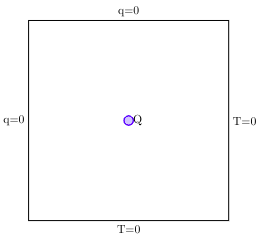

con: 

$$Q=10$$
$$\alpha =0.001$$
## Problema variacional

Encontrar un  $T \ \in \ V$  tal que 
$$
        \int \frac{\partial T}{\partial t}d\Omega +\int \alpha \nabla v \nabla T d\Omega  - \int_{\partial \Omega} \alpha q \cdot n ds - \int Qvd\Omega = 0
$$

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
time inv =0.04787945747375488
-1.1661348416891287e+78
354.4245332238246
step:0 of 200 time= 0.005
-1.2670382942375103e+77
354.39838521122357
step:1 of 200 time= 0.01
-8.568220139217884e+78
354.39238604964163
step:2 of 200 time= 0.015
1.9489231561266664e+76
354.29776816173006
step:3 of 200 time= 0.02
-8.753018580180793e+78
354.2931300899817
step:4 of 200 time= 0.025
-2.6743868951191983e+77
354.27677679398704
step:5 of 200 time= 0.030000000000000002
-1.4764178195111315e+78
354.2659128066727
step:6 of 200 time= 0.035
-2.2175323827211205e+77
354.251023109436
step:7 of 200 time= 0.04
-1.9391351125529546e+78
354.23964971480876
step:8 of 200 time= 0.045
-9.320142899696

-2.83921337139823e+78
351.85732127530173
step:107 of 200 time= 0.5400000000000004
-8.47343390745053e+76
351.82172791934283
step:108 of 200 time= 0.5450000000000004
-2.0243513825915954e+78
351.8161963191932
step:109 of 200 time= 0.5500000000000004
-6.175432459664483e+76
351.7764383392708
step:110 of 200 time= 0.5550000000000004
-1.385686814146641e+78
351.77019381125024
step:111 of 200 time= 0.5600000000000004
-4.8227481049538073e+76
351.7285589335133
step:112 of 200 time= 0.5650000000000004
-2.518334307982088e+78
351.72347429157196
step:113 of 200 time= 0.5700000000000004
-7.245821115677321e+76
351.68726208315496
step:114 of 200 time= 0.5750000000000004
-1.3921082285058895e+78
351.68255982432794
step:115 of 200 time= 0.5800000000000004
-2.7258258191482076e+77
351.6618569645748
step:116 of 200 time= 0.5850000000000004
-1.5451284822189079e+78
351.65756502494867
step:117 of 200 time= 0.5900000000000004
-8.542513038244021e+76
351.62165590836287
step:118 of 200 time= 0.5950000000000004
-1.94

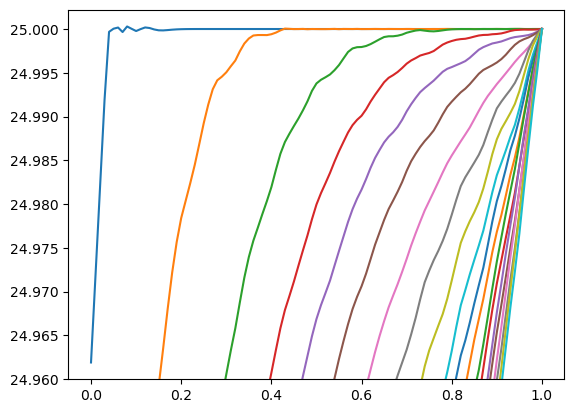

In [16]:
from __future__ import print_function
from fenics import *  # Importa FEniCS, una biblioteca popular para elementos finitos
import numpy as np  # NumPy para operaciones numéricas
import matplotlib.pyplot as plt  # Matplotlib para gráficos
import math
import time
import scipy
from matplotlib.legend_handler import HandlerLine2D
from label_lines import *

from mshr import *
start = time.time()

parameters['linear_algebra_backend'] = 'Eigen'
# def tran2SparseMatrix(A):
#     row, col, val = as_backend_type(A).data()
#     return sps.csr_matrix((val, col, row))
# mempool = cupy.get_default_memory_pool()

# with cupy.cuda.Device(0):
#     mempool.set_limit(size=4*1024**3)
    
np.set_printoptions(formatter={'float': '{: 0.2E}'.format})
# Parámetros de simulación
T = 1           # Tiempo final
num_steps = 200# Número de pasos de tiempo
dt = T / num_steps # Tamaño del paso de tiempo
k= 1
A=1
# mesh
elements = 100
start = 0
x_end = 1
mesh = IntervalMesh(elements, start, x_end)  # use for 1D
#mesh = RectangleMesh(Point(start,start), Point(x_end,x_end/8), elements, 12)  # use for 2D

# boundary markers
class LeftBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], start) and on_boundary


class RightBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], x_end) and on_boundary


boundaries= MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
boundaries.set_all(0)

LeftBoundary().mark(boundaries, 1)  # mark left boundary with a 0
RightBoundary().mark(boundaries, 2)  # mark right boundary with a 1
V=FunctionSpace(mesh,"CG",2)
# Definición de la condición inicial
u_o =Expression(('25'),degree=2)



# Definición del problema variacional
u = TrialFunction(V)  # Función de prueba
v = TestFunction(V)   # Función de test
n=FacetNormal(mesh)
ds = Measure('ds', domain=mesh, subdomain_data=boundaries)



# Definición del valor inicial
u_n = interpolate(u_o, V)  # Interpola u_D en el espacio de funciones V

bc1 =DirichletBC(V,Constant(25),boundaries,2)
#bc2 =DirichletBC(V,Constant(0),boundaries,2)
bcs=[bc1]
fem =k*dot(grad(u), grad(v))*dx -v*A*ds(1)  # Formulación débil
C_fem=u*v*dx


#ensamble vector de cargas

f=rhs(fem)
Q_v=assemble(f)
[bc.apply(Q_v) for bc in bcs] #penalización
#ensamble matriz capacitiva 
C=assemble(C_fem)
[bc.apply(C) for bc in bcs]#penalización
#ensamble matriz de rigidez
K_fem=lhs(fem)
K=assemble(K_fem)
[bc.apply(K) for bc in bcs] #penalización


#metodo sparse
K_=scipy.sparse.csr_matrix(K.array()) 
# plt.spy(s)
# plt.colorbar()
# plt.show()
N_degree=C.array().shape[0]
C=scipy.sparse.csc_matrix(C.array())
I_n=scipy.sparse.csc_matrix(scipy.sparse.identity(N_degree))
Q_v=Q_v.get_local()

start=time.time()
C_1=scipy.sparse.linalg.spsolve(C,I_n)

end = time.time()
#metodo coarse np
A=-C_1.dot(K_)
A=A.toarray()

Q=-C_1.dot(Q_v)

#C_c = tran2SparseMatrix(C)
#C_c = cupyx.scipy.sparse.csr_matrix(C_c)
#bc.apply(C)


#I_np=np.identity(N_degree)
#I_cupy=cupyx.scipy.sparse.identity(N_degree)
# A1 = assemble(L)
# [bc.apply(A1) for bc in bcs]


# b1 = assemble(R)
# [bc.apply(b1) for bc in bcs]
# b1= b1[:]
# b1 = cupy.array(b1)
# X_w.vector()[:] = cupy.asnumpy(linalge.spsolve(A1, b1))
#C_1=np.linalg.solve(C.array(),I_np)
#C_1 = cupyx.scipy.sparse.linalg.spsolve(C_c, I_cupy)



# algoritmo de arnoldi 
def arnoldi_iteration_3(A, b, n,tau):
    m = A.shape[0]

    h = np.zeros((n + 1, n))
    Q = np.zeros((m, n + 1))
    beta=np.linalg.norm(b)
    q = b / beta
    Q[:, 0] = q
    tol
    while error>tol
    for k in range(n):
        v = A.dot(q)
        for j in range(k + 1):
            h[j, k] = np.dot(Q[:, j].conj(), v)  # <-- Q needs conjugation!
            v = v - h[j, k] * Q[:, j]

        h[k + 1, k] = np.linalg.norm(v)
        eps = 1e-12
        if h[k + 1, k] > eps:
            q = v / h[k + 1, k]
            Q[:, k + 1] = q
        else:
            return Q[:,0:n], h[0:n, 0:n]
    return Q[:,0:n], h[0:n, 0:n]



t= 0
u_=Function(V)


    

print(f"time inv ={end-start}")
def Exp (A,tau=1):
    A=A.copy()
    
    A.resize(m+1,m+1)
    A[0,m]=1
    exp_m=scipy.linalg.expm(tau*A)
    return exp_m[:m,m]
def fi (A,tau=1):
    d=scipy.sparse.identity(m)
    
    return (scipy.linalg.expm(tau*A)-d)*scipy.sparse.linalg.spsolve(tau*A,d)

u_i=np.dot(A,u_n.vector().get_local())+Q
m=15
v_hat=np.zeros(m)
v_hat[0]=1
#u_i=u_n.vector()

for n in range(num_steps):
    
    t += dt
    
    
    Beta=np.linalg.norm(u_i)
    V_m,H_m = arnoldi_iteration_3(A,u_i,m)
    print(np.linalg.det(H_m))
#     u_.vector()[:]=u_i
    if n == 0:
        
        #u=dt*Beta*np.dot(V_m,Exp(H_m,dt)) + u_n.vector()
        u =  dt*Beta*np.dot(np.dot(V_m,fi(H_m,dt)),v_hat.T)+u_n.vector().get_local()
#        u =  dt*np.dot((np.dot((scipy.linalg.expm(dt*A)-I_n),A_i)),(np.dot(A,u_n.vector().get_local())+Q)) +u_n.vector().get_local()
    else:
        #u += dt*Beta*np.dot(V_m,Exp(H_m,dt))
        u += dt*Beta*np.dot(np.dot(V_m,fi(dt*H_m)),v_hat.T)
#         u +=  dt*np.dot((np.dot((scipy.linalg.expm(dt*A)-I_n),A_i)),(np.dot(A,np.array(u)[0])+Q)) 
        #u_i=np.dot(scipy.linalg.expm(dt*A),u_i)
    u_.vector()[:]=np.array(u)[0]
    u_i=np.dot(A,np.array(u)[0])+Q
    Beta=np.linalg.norm(u)
    print(Beta)
    if n%10==0:
        plot(u_)
    
    print(f'step:{n} of {num_steps} time= {t}')

time: 0.0001
time: 1.00005
time: 2.0


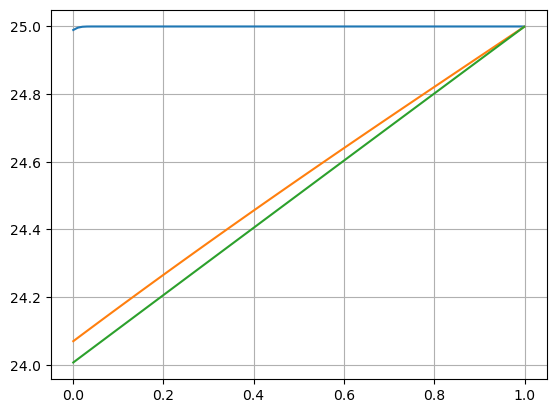

In [10]:
import numpy as np
import math
import matplotlib.pyplot as plt 
def b_n(n):
    return 8/((1-2*n)**2*np.pi**2)
def Analytic(x,t):
    print('time:', t)
    s_m=1000
    u=[]
    j=0
    for x_n in x:
        u_j=0
        for n in range(1,s_m):
            u_j += b_n(n)*math.exp(-1*((n-0.5)*np.pi)**2*t)*np.cos((n-0.5)*np.pi*x_n)
        u_j += x_n+24
        u.append(u_j)
    return u
x_a=np.linspace(0.001,0.999,100)
t_=np.linspace(0.0001,2,3)
for t in t_:
    u_a =Analytic(x_a,t )
    plt.plot(x_a,u_a)
plt.grid(True)

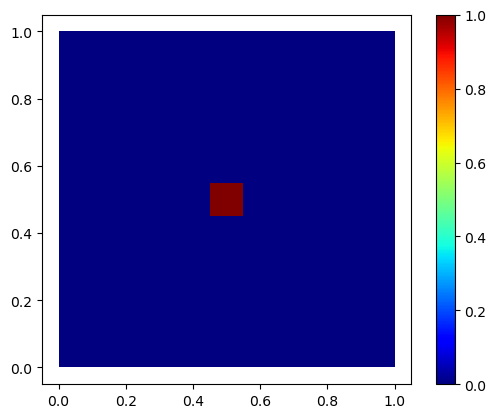

In [2]:
p=plot(subdomain)
p.set_cmap ('jet')
plt.colorbar(p)
plt.show()

time:  0.0016666666666666668
Solving linear variational problem.
time:  0.0033333333333333335
time:  0.005
time:  0.006666666666666667
time:  0.008333333333333333
time:  0.01
time:  0.011666666666666667
time:  0.013333333333333334
time:  0.015000000000000001
time:  0.016666666666666666
time:  0.018333333333333333
time:  0.02
time:  0.021666666666666667
time:  0.023333333333333334
time:  0.025
time:  0.02666666666666667
time:  0.028333333333333335
time:  0.030000000000000002
time:  0.03166666666666667
time:  0.03333333333333333
time:  0.034999999999999996
time:  0.03666666666666666
time:  0.03833333333333332
time:  0.03999999999999999
time:  0.04166666666666665
time:  0.043333333333333314
time:  0.04499999999999998
time:  0.04666666666666664
time:  0.048333333333333305
time:  0.04999999999999997
time:  0.05166666666666663
time:  0.053333333333333295
time:  0.05499999999999996
time:  0.05666666666666662
time:  0.058333333333333286
time:  0.05999999999999995
time:  0.06166666666666661
tim

Solving linear variational problem.
time:  0.5216666666666652
time:  0.5233333333333319
time:  0.5249999999999986
time:  0.5266666666666653
time:  0.528333333333332
time:  0.5299999999999987
time:  0.5316666666666654
time:  0.5333333333333321
time:  0.5349999999999988
time:  0.5366666666666655
time:  0.5383333333333322
time:  0.5399999999999989
time:  0.5416666666666656
time:  0.5433333333333323
time:  0.544999999999999
time:  0.5466666666666657
time:  0.5483333333333325
time:  0.5499999999999992
time:  0.5516666666666659
time:  0.5533333333333326
time:  0.5549999999999993
time:  0.556666666666666
time:  0.5583333333333327
time:  0.5599999999999994
time:  0.5616666666666661
time:  0.5633333333333328
time:  0.5649999999999995
time:  0.5666666666666662
time:  0.5683333333333329
time:  0.5699999999999996
time:  0.5716666666666663
time:  0.573333333333333
time:  0.5749999999999997
time:  0.5766666666666664
time:  0.5783333333333331
time:  0.5799999999999998
time:  0.5816666666666666
time: 

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational p

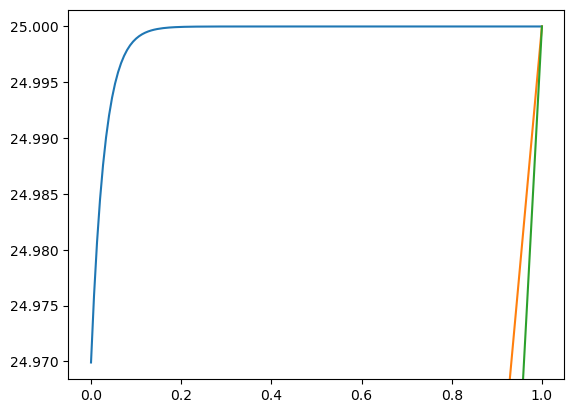

In [9]:
from __future__ import print_function
from fenics import *  # Importa FEniCS, una biblioteca popular para elementos finitos
import numpy as np  # NumPy para operaciones numéricas
import matplotlib.pyplot as plt  # Matplotlib para gráficos
import math
import time


from mshr import *
start = time.time()

parameters['linear_algebra_backend'] = 'Eigen'
# def tran2SparseMatrix(A):
#     row, col, val = as_backend_type(A).data()
#     return sps.csr_matrix((val, col, row))
# mempool = cupy.get_default_memory_pool()

# with cupy.cuda.Device(0):
#     mempool.set_limit(size=4*1024**3)
    
np.set_printoptions(formatter={'float': '{: 0.2E}'.format})
# Parámetros de simulación
T = 1           # Tiempo final
num_steps = 600# Número de pasos de tiempo
dt = T / num_steps # Tamaño del paso de tiempo
k= 1
A=-1
# mesh
elements = 150
start = 0
x_end = 1
mesh = IntervalMesh(elements, start, x_end)  # use for 1D
#mesh = RectangleMesh(Point(start,start), Point(x_end,x_end/8), elements, 12)  # use for 2D

# boundary markers
class LeftBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], start) and on_boundary


class RightBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], x_end) and on_boundary


boundaries= MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
boundaries.set_all(0)

LeftBoundary().mark(boundaries, 1)  # mark left boundary with a 0
RightBoundary().mark(boundaries, 2)  # mark right boundary with a 1
V=FunctionSpace(mesh,"CG",1)
# Definición de la condición inicial
u_o =Expression(('25'),degree=2)



# Definición del problema variacional
u = TrialFunction(V)  # Función de prueba
v = TestFunction(V)   # Función de test
n=FacetNormal(mesh)





# Definición del valor inicial
u_n = interpolate(u_o, V)  # Interpola u_D en el espacio de funciones V
u_nn = interpolate(u_o, V) 
u_nnn = interpolate(u_o, V) 


# Formulación del problema variacional
#pconst=[3./2,-2,1./2,0.0] #bdf2
#pconst = [0.48*11/6+0.52*3/2,0.48*-3+0.52*-2,0.48*3/2+0.52*1/2,0.48*-1/3] #bdf2 op
pconst= [11/6,-3,3/2,-1/3] #bdf 3
#pconst=[1,-1,0,0] #bdf1

du=pconst[0]*u
du_n=pconst[1]*u_n
du_nn=pconst[2]*u_nn
du_nnn=pconst[3]*u_nnn
du_t= du+du_n +du_nn +du_nnn
t= 0

#bc1 =DirichletBC(V,Constant(20),boundaries,1)
bc2 =DirichletBC(V,Constant(25),boundaries,2)
bcs=[bc2]
ds = Measure('ds', domain=mesh, subdomain_data=boundaries)
F = du_t*v*dx + dt*k*dot(grad(u), grad(v))*dx - dt*v*A*ds(1)# Formulación débil

a, L = lhs(F), rhs(F)  # Separa la parte izquierda y derecha de la ecuación

u_=Function(V)
for n in range(num_steps):
    

    # Actualizar el tiempo actual
    t += dt
    print("time: ", t)
    # Resolver la solución
#     A=assemble(a)
#     b=assemble(L)
#     [bc.apply(A) for bc in bcs]
#     [bc.apply(b) for bc in bcs]
#     solve(A, u_.vector(),b)
    solve(a==L,u_,bc2)
    # Graficar la solución
    #print(f'step:{n} of {num_steps}')
    #print(np.array(u_.vector()).max())
    # Calcular el error
#     u_e = interpolate(u_D, V)  # Interpolar la solución exacta
#     error = np.abs(np.array(u_e.vector()) - np.array(u.vector())).max()  # Error máximo
#     print('t = %.2f: error = %.3g' % (t, error))

    # Actualizar la solución anterior
    u_nnn.assign(u_nn)
    u_nn.assign(u_n)
    u_n.assign(u_)
    if n%200==0:
        plot(u_)

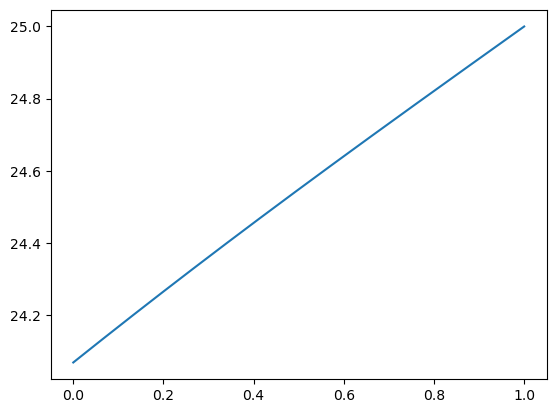

In [8]:
plot(u_)

AttributeError: 'list' object has no attribute 'set_cmap'

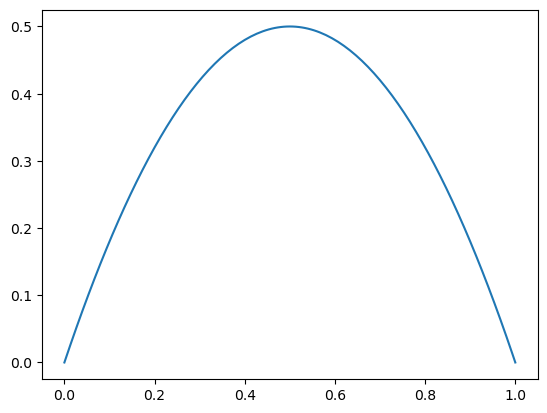

In [56]:
p=plot(u_n)
p.set_cmap ('jet')
plt.colorbar(p)

plt.show()